# Threat Detect - Network Traffic Classification Model Training
This notebook demonstrates the training and evaluation of machine learning models for network traffic classification. We'll train multiple models to classify network traffic into different categories: normal traffic, DDoS attacks, and port scanning attacks.

## Overview
- Data loading and preprocessing
- Feature scaling and class balancing
- Model training and hyperparameter tuning
- Model evaluation and comparison
- Feature importance analysis
- Model persistence

## 1. Import Required Libraries

We'll use the following libraries:
- **pandas & numpy**: For data manipulation and numerical operations
- **scikit-learn**: For machine learning models, preprocessing, and evaluation
- **imbalanced-learn**: For handling class imbalance using SMOTE
- **joblib**: For model persistence

In [ ]:
# --- 1. Imports ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import roc_curve, auc
from imblearn.over_sampling import SMOTE
from google.colab import files
import joblib
import os
import joblib

## 2. Data Loading and Preprocessing

We'll load and combine different types of network traffic data:
- Normal traffic (`normal_data.csv`)
- DDoS attacks (`ddos_attack.csv` and `ddos_attack2.csv`)
- Port scanning attacks (`port_scaning.csv`)

Each dataset will be labeled appropriately and combined into a single DataFrame.

Dataset Shape: (63157, 21)

Class Distribution:
Label
normal      21440
ddos        21360
portscan    20357
Name: count, dtype: int64


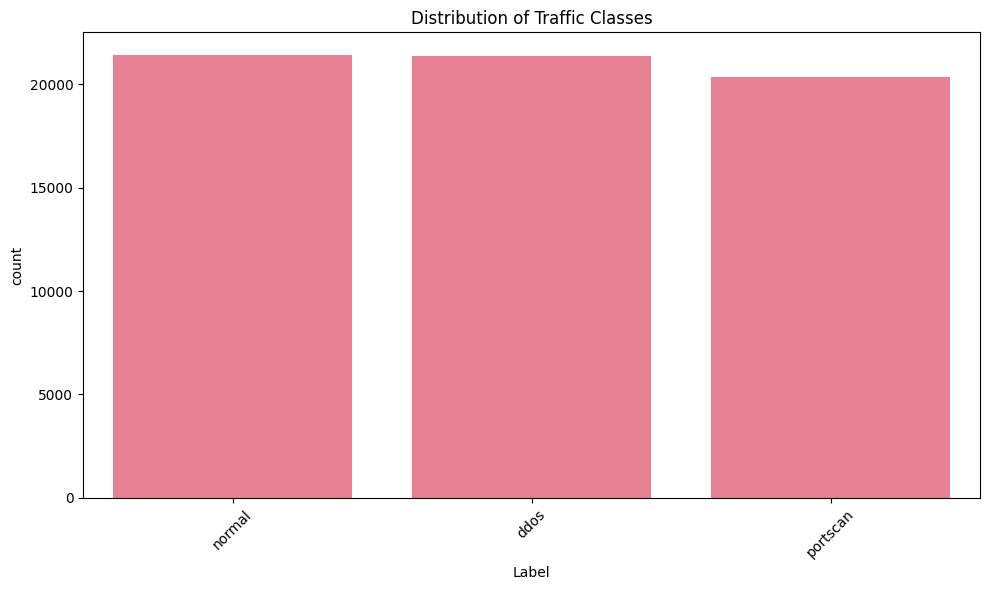

In [ ]:
# --- 2. Load and Combine Data ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Using Seaborn's default style implicitly
sns.set_palette('husl') # Seaborn itself will set the style

# Load individual datasets
normal = pd.read_csv('normal_data.csv')
ddos1 = pd.read_csv('ddos_attack.csv')
ddos2 = pd.read_csv('ddos_attack2.csv')
portscan = pd.read_csv('port_scaning.csv')

# Add labels
normal['Label'] = 'normal'
ddos1['Label'] = 'ddos'
ddos2['Label'] = 'ddos'
portscan['Label'] = 'portscan'

# Combine datasets
df = pd.concat([normal, ddos1, ddos2, portscan], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # shuffle

# Display dataset information
print("Dataset Shape:", df.shape)
print("\nClass Distribution:")
print(df['Label'].value_counts())

# Visualize class distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Label')
plt.title('Distribution of Traffic Classes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Class Distribution Analysis

The plot above shows the distribution of traffic classes in our combined dataset:
- **Normal**: 21,440 samples
- **DDoS**: 21,360 samples
- **Portscan**: 20,357 samples

**Analysis:**
- The dataset is well-balanced as the data was derived from the custom python script on real time network traffic, with a similar number of samples for each class.
- This balance is important for training machine learning models, as it helps prevent bias toward any particular class.
- A balanced dataset ensures that the model will have enough examples to learn the characteristics of each traffic type, leading to more reliable and fair predictions.

If you notice any significant imbalance in your own data, consider using techniques like SMOTE (as we do later) to address it.

## 3. Data Preprocessing

Our preprocessing pipeline includes:
1. Separating features and target variables
2. Handling missing and infinite values
3. Feature scaling using RobustScaler
   - More robust to outliers than StandardScaler
   - Important for network traffic data which often contains outliers

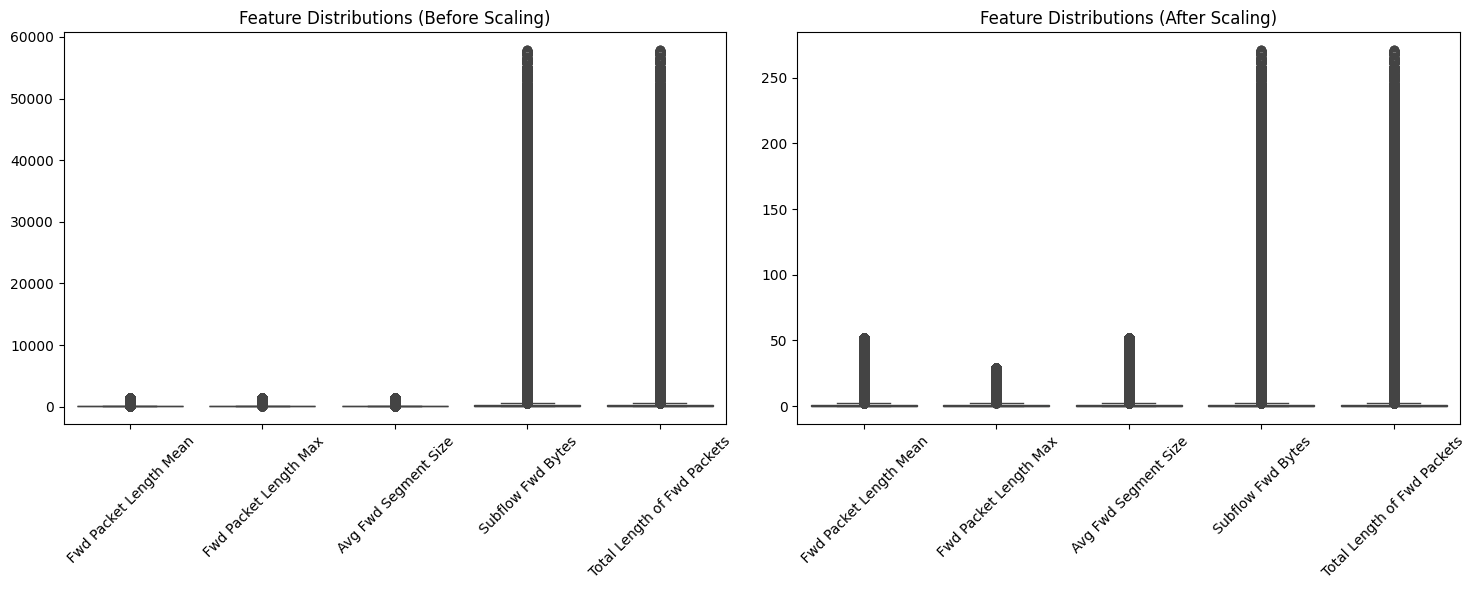

In [ ]:
# --- 3. Preprocessing ---
X = df.drop('Label', axis=1)
y = df['Label']

# Fill missing/infinite values
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

# Scale features
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Visualize feature distributions before and after scaling
plt.figure(figsize=(15, 6))

# Before scaling
plt.subplot(1, 2, 1)
sns.boxplot(data=X.iloc[:, :5])
plt.title('Feature Distributions (Before Scaling)')
plt.xticks(rotation=45)

# After scaling
plt.subplot(1, 2, 2)
sns.boxplot(data=pd.DataFrame(X_scaled[:, :5], columns=X.columns[:5]))
plt.title('Feature Distributions (After Scaling)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Feature Distribution Analysis (Before and After Scaling)

The plots above compare the distributions of selected features before and after applying `RobustScaler`:

- **Before Scaling:**  
  - The left plot shows that some features have extremely large values and significant outliers.
  - The wide range and presence of outliers can negatively impact many machine learning algorithms, especially those sensitive to feature scale.

- **After Scaling:**  
  - The right plot demonstrates that the features are now on a more comparable scale.
  - `RobustScaler` reduces the influence of outliers by using the median and interquartile range, rather than the mean and standard deviation.
  - The spread of the data is more uniform, and extreme values are less pronounced.


## 4. Train/Test Split

We'll split our data into training and testing sets using stratified sampling to maintain class distribution. This ensures that both sets have similar proportions of each traffic type.

Training set shape: (50525, 20)
Testing set shape: (12632, 20)


<ipython-input-5-682226c0f281>:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
<ipython-input-5-682226c0f281>:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)


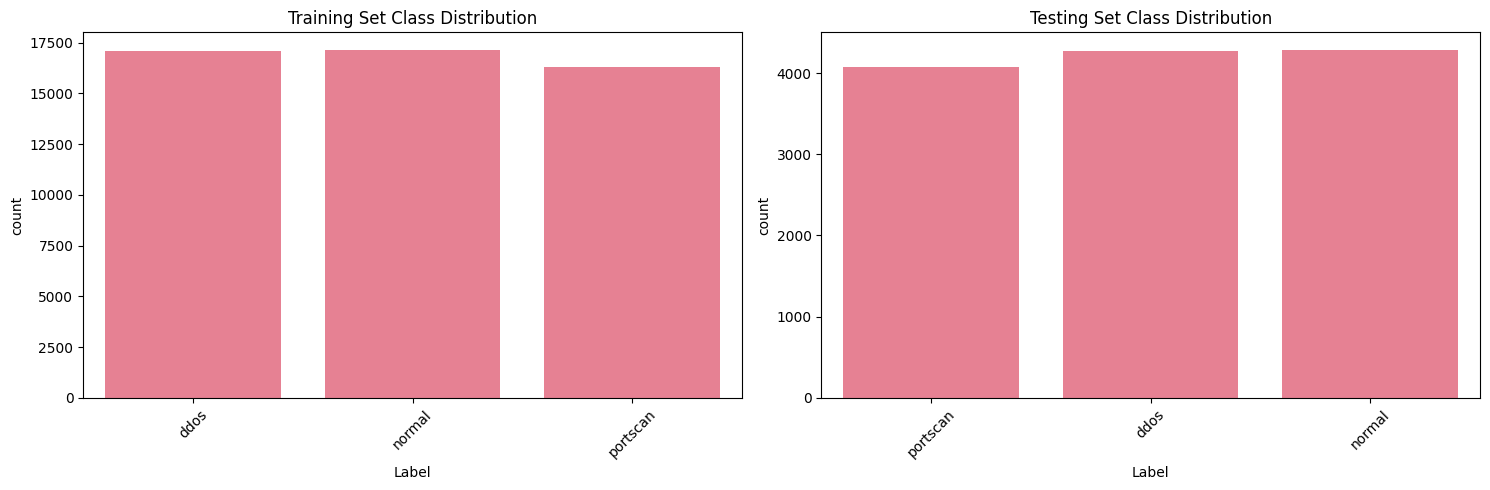

In [ ]:
# --- 4. Train/Test Split (Stratified) ---
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

# Visualize class distribution in train and test sets
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sns.countplot(x=y_train, ax=ax1)
ax1.set_title('Training Set Class Distribution')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

sns.countplot(x=y_test, ax=ax2)
ax2.set_title('Testing Set Class Distribution')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

### Train/Test Split Class Distribution Analysis

The plots above show the class distribution in the training and testing sets after performing a stratified split:

- **Training Set:** Contains 50,525 samples, with each class (normal, ddos, portscan) represented in similar proportions.
- **Testing Set:** Contains 12,632 samples, also with balanced class proportions.

**Analysis:**
- The stratified split has successfully preserved the original class distribution in both the training and testing sets.
- This is important for fair model evaluation, as it ensures that the model is tested on data that reflects the real-world distribution of classes.
- No class is underrepresented in either set, which helps prevent biased performance metrics and supports robust model training and evaluation.

## 5. Class Balancing

We'll use SMOTE (Synthetic Minority Over-sampling Technique) to balance our classes. This is important because:
- Network traffic data is often imbalanced
- Balanced classes help prevent model bias
- SMOTE creates synthetic samples of minority classes

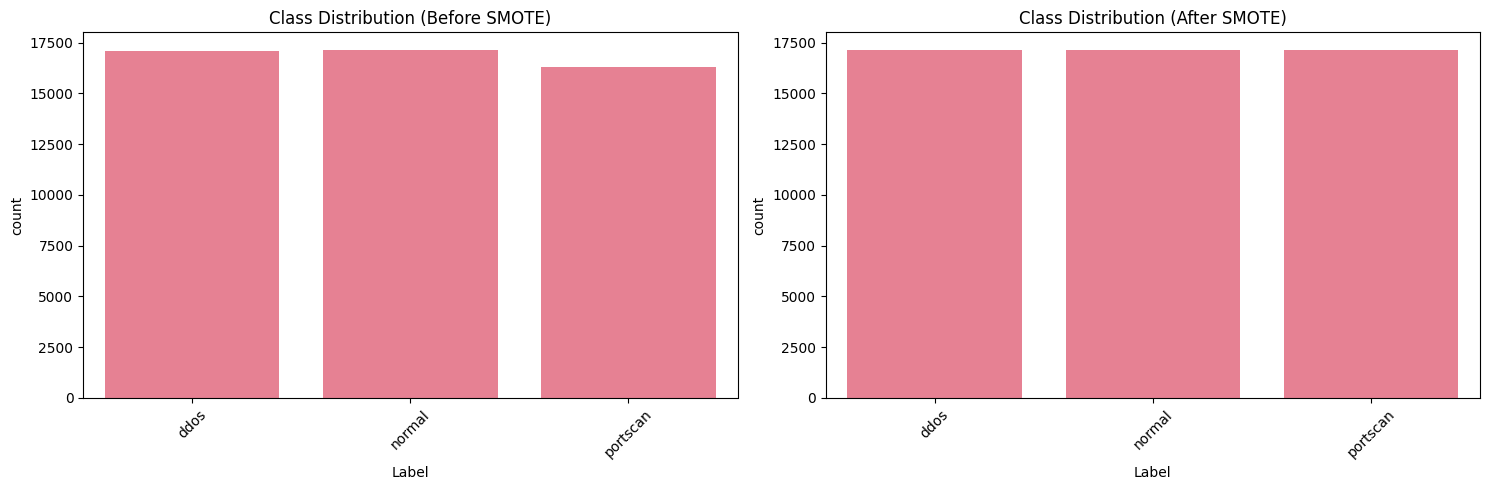

In [ ]:
# --- 5. Class Balancing (SMOTE) ---
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# Visualize class distribution before and after SMOTE
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sns.countplot(x=y_train, ax=ax1)
ax1.set_title('Class Distribution (Before SMOTE)')
ax1.tick_params(axis='x', rotation=45)

sns.countplot(x=y_train_bal, ax=ax2)
ax2.set_title('Class Distribution (After SMOTE)')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 6. Model Training and Evaluation

We'll train and evaluate three different models:
1. **Random Forest**: Ensemble of decision trees, good for complex patterns
2. **K-Nearest Neighbors**: Instance-based learning, good for local patterns
3. **Decision Tree**: Simple, interpretable model

For each model, we'll:
- Perform hyperparameter tuning using GridSearchCV
- Evaluate using multiple metrics
- Generate visualizations

In [ ]:
# --- 6. Model Definitions and Hyperparameters ---
models = {
    'RandomForest': (
        RandomForestClassifier(random_state=42),
        {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5]
        }
    ),
    'KNN': (
        KNeighborsClassifier(),
        {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance']
        }
    ),
    'DecisionTree': (
        DecisionTreeClassifier(random_state=42),
        {
            'max_depth': [5, 10, 20, None],
            'min_samples_split': [2, 5]
        }
    )
}

results = {}
os.makedirs('../models', exist_ok=True)


## 7. Model Training and Evaluation

We'll train multiple models and evaluate their performance using various metrics:
- Precision, Recall, and F1-score for each class
- Confusion matrices to visualize predictions
- ROC curves for probability-based evaluation
- Feature importance analysis for tree-based models

In [ ]:
# --- 7.1 Model Setup ---
# Define model filenames
model_filenames = {
    'RandomForest': 'scapy_Random_Forest.pkl',
    'KNN': 'scapy_KNN.pkl',
    'DecisionTree': 'scapy_Decision_Tree.pkl'
}

# Create directory for models
os.makedirs('../models', exist_ok=True)

# Dictionary to store results
results = {}


Training RandomForest

Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}

Classification Report:
              precision    recall  f1-score   support

        ddos       0.95      1.00      0.97      4272
      normal       1.00      0.99      1.00      4288
    portscan       1.00      0.95      0.98      4072

    accuracy                           0.98     12632
   macro avg       0.98      0.98      0.98     12632
weighted avg       0.98      0.98      0.98     12632



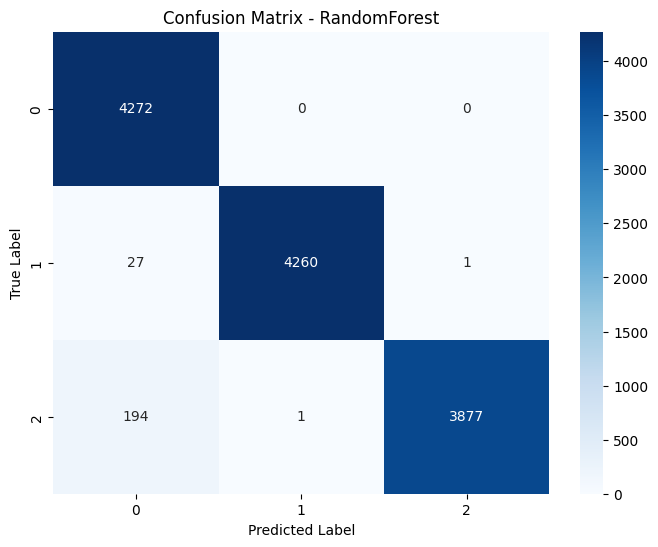

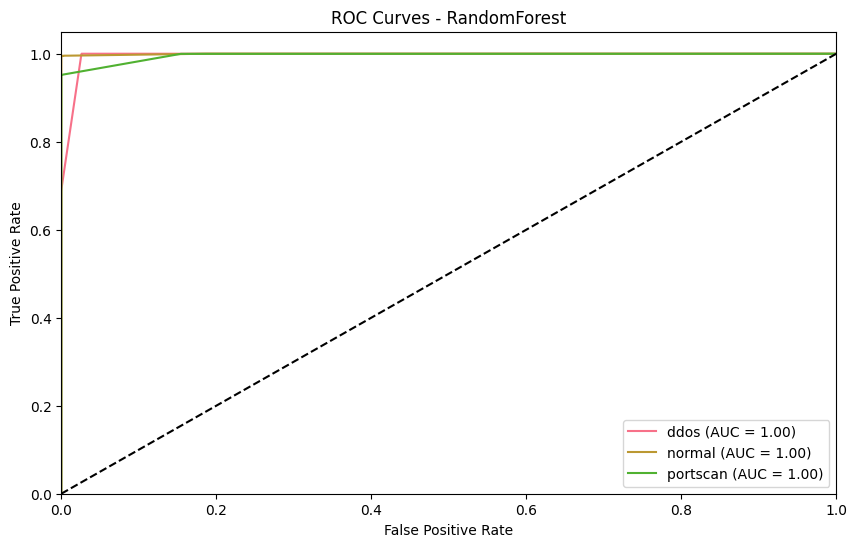


Model saved as ../models/scapy_Random_Forest.pkl


In [ ]:
# --- 7.2 Random Forest Training and Evaluation ---
name = 'RandomForest'
model, params = models[name]

print(f"\n{'='*50}")
print(f"Training {name}")
print(f"{'='*50}")

# Grid search
grid = GridSearchCV(
    model, params,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    scoring='f1_weighted',
    n_jobs=-1
)
grid.fit(X_train_bal, y_train_bal)

# Get best model
best_model = grid.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)

# Print results
print(f"\nBest Parameters: {grid.best_params_}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot ROC curves
plt.figure(figsize=(10, 6))
for i, label in enumerate(np.unique(y)):
    fpr, tpr, _ = roc_curve(y_test == label, y_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')


plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curves - {name}')
plt.legend(loc="lower right")
plt.show()

# Store results
results[name] = {
    'model': best_model,
    'params': grid.best_params_,
    'report': classification_report(y_test, y_pred, output_dict=True)
}

# Save model
model_path = f'../models/{model_filenames[name]}'
joblib.dump(best_model, model_path)
print(f"\nModel saved as {model_path}")

### Random Forest Model Evaluation

**Classification Report:**
- The Random Forest model achieves very high precision, recall, and F1-scores for all classes:
  - **DDoS:** Precision = 0.95, Recall = 1.00, F1-score = 0.97
  - **Normal:** Precision = 1.00, Recall = 0.99, F1-score = 1.00
  - **Portscan:** Precision = 1.00, Recall = 0.95, F1-score = 0.98
- **Overall accuracy:** 98%

**Confusion Matrix:**
- Most predictions are on the diagonal, indicating correct classification.
- Very few misclassifications:
  - 27 normal samples were predicted as ddos.
  - 194 portscan samples were predicted as ddos.
  - Only 1 normal sample was misclassified as portscan.

**ROC Curves:**
- The ROC curves for all classes are very close to the top-left corner, with AUC (Area Under Curve) values of 1.00 for each class.
- This indicates excellent separability between the classes and outstanding model performance.

**Summary:**
- The Random Forest model is highly effective at distinguishing between normal, ddos, and portscan traffic.
- The model is robust, with minimal misclassifications and near-perfect ROC-AUC scores.
- This makes it a strong candidate for deployment in our network traffic classification system.


Training KNN

Best Parameters: {'n_neighbors': 3, 'weights': 'distance'}

Classification Report:
              precision    recall  f1-score   support

        ddos       0.95      1.00      0.97      4272
      normal       1.00      0.99      1.00      4288
    portscan       1.00      0.95      0.98      4072

    accuracy                           0.98     12632
   macro avg       0.98      0.98      0.98     12632
weighted avg       0.98      0.98      0.98     12632



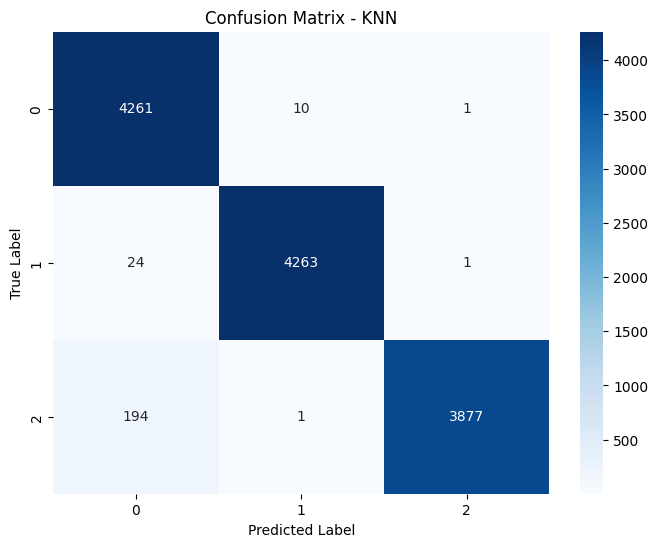

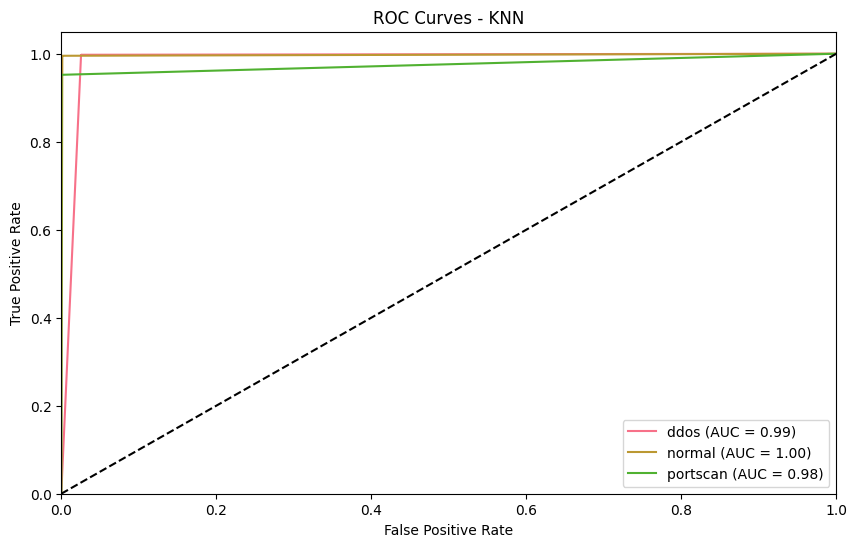


Model saved as ../models/scapy_KNN.pkl


In [ ]:
# --- 7.3 KNN Training and Evaluation ---
name = 'KNN'
model, params = models[name]

print(f"\n{'='*50}")
print(f"Training {name}")
print(f"{'='*50}")

# Grid search
grid = GridSearchCV(
    model, params,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    scoring='f1_weighted',
    n_jobs=-1
)
grid.fit(X_train_bal, y_train_bal)

# Get best model
best_model = grid.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)

# Print results
print(f"\nBest Parameters: {grid.best_params_}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot ROC curves
plt.figure(figsize=(10, 6))
for i, label in enumerate(np.unique(y)):
    fpr, tpr, _ = roc_curve(y_test == label, y_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curves - {name}')
plt.legend(loc="lower right")
plt.show()

# Store results
results[name] = {
    'model': best_model,
    'params': grid.best_params_,
    'report': classification_report(y_test, y_pred, output_dict=True)
}

# Save model
model_path = f'../models/{model_filenames[name]}'
joblib.dump(best_model, model_path)
print(f"\nModel saved as {model_path}")

### K-Nearest Neighbors (KNN) Model Evaluation

**Classification Report:**
- The KNN model achieves very high scores across all classes:
  - **DDoS:** Precision = 0.95, Recall = 1.00, F1-score = 0.97
  - **Normal:** Precision = 1.00, Recall = 0.99, F1-score = 1.00
  - **Portscan:** Precision = 1.00, Recall = 0.95, F1-score = 0.98
- **Overall accuracy:** 98%
- **Macro and weighted averages** are both 0.98, indicating balanced performance across classes.

**Confusion Matrix:**
- Most predictions are correct (on the diagonal).
- Misclassifications are minimal:
  - 10 ddos samples were predicted as normal, and 1 as portscan.
  - 24 normal samples were predicted as ddos, and 1 as portscan.
  - 194 portscan samples were predicted as ddos, and 1 as normal.
- The largest confusion is between portscan and ddos, similar to the other models.

**ROC Curves:**
- The ROC curves show strong performance for all classes:
  - **DDoS:** AUC = 0.99
  - **Normal:** AUC = 1.00
  - **Portscan:** AUC = 0.98
- The curves are close to the top-left corner, indicating high true positive rates and low false positive rates.

**Summary:**
- The KNN model is highly effective at distinguishing between normal, ddos, and portscan traffic.
- Its performance is very similar to Random Forest and Decision Tree, with only minor differences in misclassification patterns and AUC values.
- KNN is a strong, simple baseline for network traffic classification.


Training DecisionTree

Best Parameters: {'max_depth': 10, 'min_samples_split': 5}

Classification Report:
              precision    recall  f1-score   support

        ddos       0.95      1.00      0.97      4272
      normal       1.00      0.99      1.00      4288
    portscan       1.00      0.95      0.98      4072

    accuracy                           0.98     12632
   macro avg       0.98      0.98      0.98     12632
weighted avg       0.98      0.98      0.98     12632



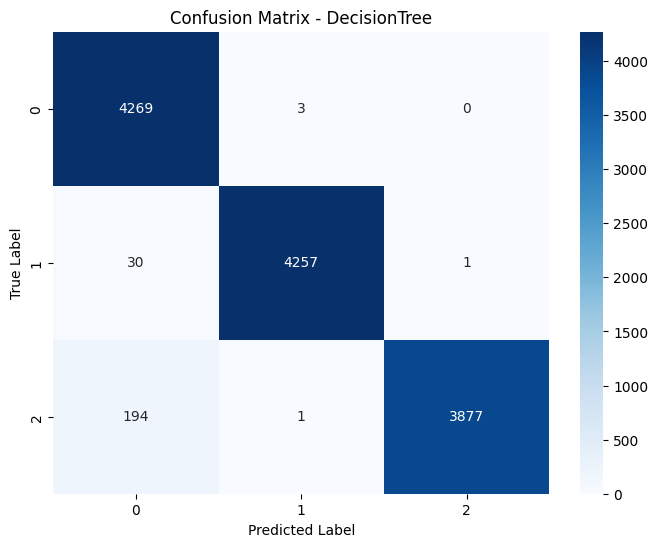

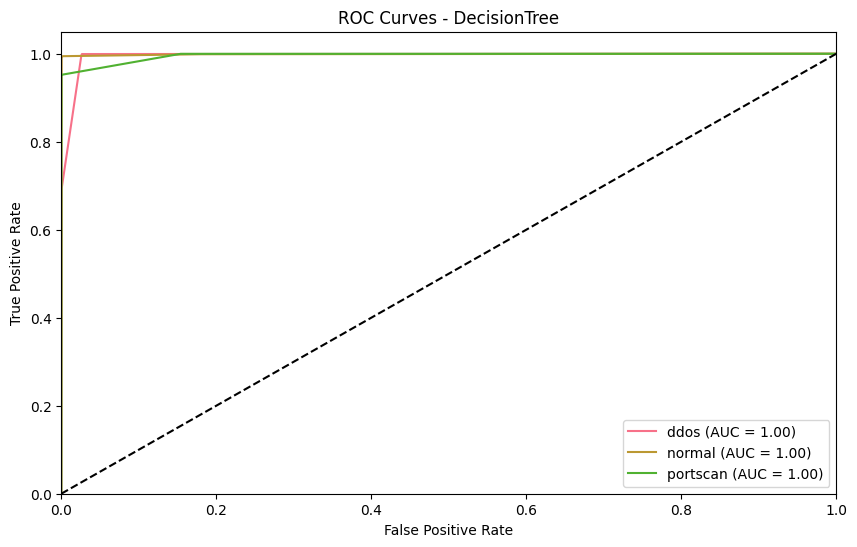


Model saved as ../models/scapy_Decision_Tree.pkl


In [ ]:
# --- 7.4 Decision Tree Training and Evaluation ---
name = 'DecisionTree'
model, params = models[name]

print(f"\n{'='*50}")
print(f"Training {name}")
print(f"{'='*50}")

# Grid search
grid = GridSearchCV(
    model, params,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    scoring='f1_weighted',
    n_jobs=-1
)
grid.fit(X_train_bal, y_train_bal)

# Get best model
best_model = grid.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)

# Print results
print(f"\nBest Parameters: {grid.best_params_}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot ROC curves
plt.figure(figsize=(10, 6))
for i, label in enumerate(np.unique(y)):
    fpr, tpr, _ = roc_curve(y_test == label, y_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curves - {name}')
plt.legend(loc="lower right")
plt.show()

# Store results
results[name] = {
    'model': best_model,
    'params': grid.best_params_,
    'report': classification_report(y_test, y_pred, output_dict=True)
}

# Save model
model_path = f'../models/{model_filenames[name]}'
joblib.dump(best_model, model_path)
print(f"\nModel saved as {model_path}")

### Decision Tree Model Evaluation

**Classification Report:**
- The Decision Tree model achieves high precision, recall, and F1-scores for all classes:
  - **DDoS:** Precision = 0.95, Recall = 1.00, F1-score = 0.97
  - **Normal:** Precision = 1.00, Recall = 0.99, F1-score = 1.00
  - **Portscan:** Precision = 1.00, Recall = 0.95, F1-score = 0.98
- **Overall accuracy:** 98%

**Confusion Matrix:**
- Most predictions are correct (on the diagonal).
- Misclassifications are minimal:
  - 3 ddos samples were predicted as normal.
  - 30 normal samples were predicted as ddos, and 1 as portscan.
  - 194 portscan samples were predicted as ddos, and 1 as normal.
- The largest confusion is again between portscan and ddos, similar to the other models.

**ROC Curves:**
- The ROC curves for all classes are very close to the top-left corner, with AUC values of 1.00 for each class.
- This indicates excellent separability and model performance.

**Summary:**
- The Decision Tree model performs on par with Random Forest and KNN, achieving high accuracy and strong class separation.
- Like the other models, it is highly effective at distinguishing between normal, ddos, and portscan traffic, with only minor confusion between portscan and ddos.
- Decision Trees are also interpretable, making them useful for understanding which features drive predictions.

## 8. Feature Importance Analysis

We'll analyze and visualize the importance of features for tree-based models (Random Forest and Decision Tree). This helps us understand:
- Which features are most influential in making predictions
- How different models prioritize different features
- Potential areas for feature engineering or selection

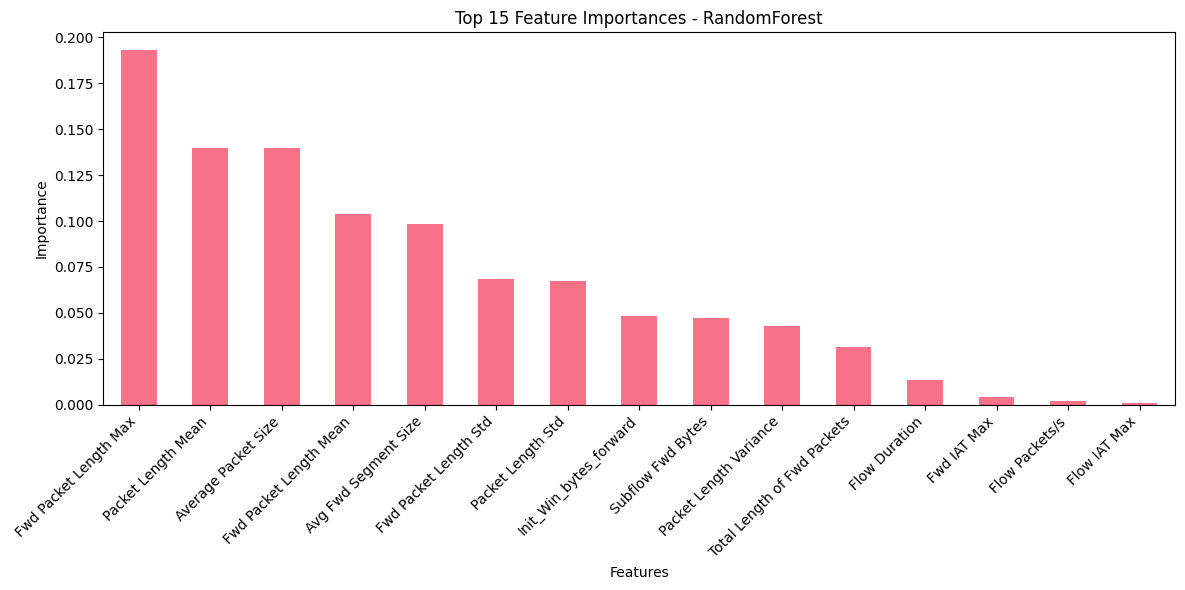


RandomForest Top 10 Feature Importances:
 Fwd Packet Length Max     0.193123
 Packet Length Mean        0.139739
 Average Packet Size       0.139689
 Fwd Packet Length Mean    0.103611
 Avg Fwd Segment Size      0.098663
 Fwd Packet Length Std     0.068274
 Packet Length Std         0.067402
Init_Win_bytes_forward     0.048245
 Subflow Fwd Bytes         0.047049
 Packet Length Variance    0.042834
dtype: float64


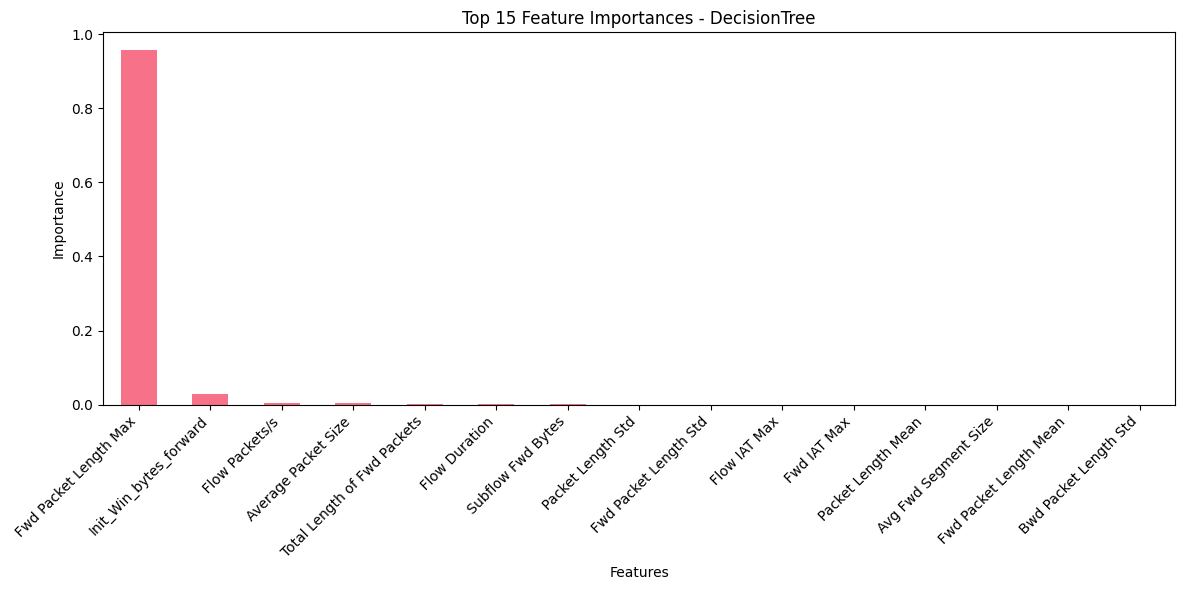


DecisionTree Top 10 Feature Importances:
 Fwd Packet Length Max         0.956740
Init_Win_bytes_forward         0.028822
 Flow Packets/s                0.004764
 Average Packet Size           0.004212
Total Length of Fwd Packets    0.002918
 Flow Duration                 0.000952
 Subflow Fwd Bytes             0.000711
 Packet Length Std             0.000453
 Fwd Packet Length Std         0.000177
 Flow IAT Max                  0.000150
dtype: float64


In [ ]:
# --- 8. Feature Importance Analysis ---
for name in ['RandomForest', 'DecisionTree']:
    if hasattr(results[name]['model'], 'feature_importances_'):
        importances = results[name]['model'].feature_importances_
        feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)

        # Plot top 15 features
        plt.figure(figsize=(12, 6))
        feat_imp.head(15).plot(kind='bar')
        plt.title(f'Top 15 Feature Importances - {name}')
        plt.xlabel('Features')
        plt.ylabel('Importance')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

        # Print top 10 features
        print(f"\n{name} Top 10 Feature Importances:")
        print(feat_imp.head(10))

### Feature Importance Analysis

The plots above show the top 15 feature importances as determined by the Random Forest and Decision Tree models.

**Random Forest:**
- The importance is distributed across several features, with the top contributors being:
  - **Fwd Packet Length Max**
  - **Packet Length Mean**
  - **Average Packet Size**
  - **Fwd Packet Length Mean**
  - **Avg Fwd Segment Size**
- This indicates that the Random Forest model leverages a combination of packet length statistics and flow characteristics to make its predictions.
- The spread of importance suggests the model is using a diverse set of features for robust classification.

**Decision Tree:**
- The Decision Tree model assigns overwhelming importance to a single feature: **Fwd Packet Length Max**.
- Other features, such as **Init_Win_bytes_forward** and **Flow Packets/s**, have much lower importance.
- This suggests that the Decision Tree is making most of its splits based on the maximum forward packet length, potentially making it more sensitive to this feature and less robust to changes in the data.

**Comparison and Insights:**
- **Random Forest** provides a more balanced view of feature importance, which generally leads to better generalization and robustness.
- **Decision Tree**'s reliance on a single feature may make it more interpretable but also more prone to overfitting if that feature's distribution changes.
- Understanding feature importance helps in:
  - Interpreting model decisions
  - Identifying which network characteristics are most relevant for traffic classification
  - Guiding future feature engineering or data collection efforts

**Conclusion:**  
Packet length statistics, especially the maximum forward packet length, are critical for distinguishing between normal, ddos, and portscan traffic in this dataset.

## 9. Model Comparison

Let's compare the performance of all models using various metrics:
- F1-score (weighted average)
- Precision (weighted average)
- Recall (weighted average)

This will help us identify the best performing model for our network traffic classification task.

<Figure size 1200x600 with 0 Axes>

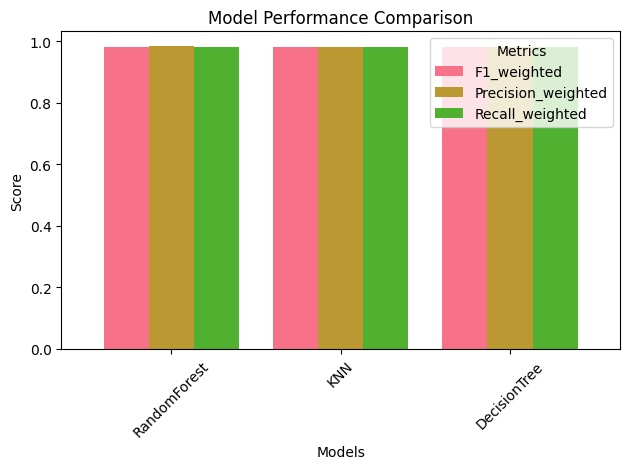


Model Performance Summary:
              F1_weighted  Precision_weighted  Recall_weighted
RandomForest     0.982374            0.983203         0.982346
KNN              0.981736            0.982500         0.981713
DecisionTree     0.981904            0.982738         0.981871


In [ ]:
# --- 9. Model Comparison ---
# Create comparison DataFrame
comparison = pd.DataFrame({
    name: {
        'F1_weighted': results[name]['report']['weighted avg']['f1-score'],
        'Precision_weighted': results[name]['report']['weighted avg']['precision'],
        'Recall_weighted': results[name]['report']['weighted avg']['recall']
    }
    for name in results
}).T

# Plot comparison
plt.figure(figsize=(12, 6))
comparison.plot(kind='bar', width=0.8)
plt.title('Model Performance Comparison')
plt.xlabel('Models')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(title='Metrics')
plt.tight_layout()
plt.show()

print("\nModel Performance Summary:")
print(comparison)

### Model Performance Comparison

The bar plot and summary table above compare the performance of the three models—Random Forest, KNN, and Decision Tree—using weighted averages of F1-score, Precision, and Recall.

**Key Observations:**
- **All three models perform exceptionally well**, with scores above 0.98 for all metrics.
- **Random Forest** has the highest scores across all metrics, but the differences are very small:
  - F1-weighted: 0.982
  - Precision-weighted: 0.983
  - Recall-weighted: 0.982
- **KNN** and **Decision Tree** also achieve nearly identical results, with only minor variations in the third decimal place.
- The close performance indicates that the classification task is well-defined and the features are highly informative for distinguishing between classes.

**Conclusion:**
- Any of these models would be suitable for deployment, but **Random Forest** offers a slight edge in overall performance and robustness.
- The high and consistent scores across all metrics suggest that the models are not only accurate but also balanced in their predictions, with no significant bias toward any class.
- This strong performance is a result of good data preprocessing, balanced class distribution, and effective feature selection.



## 10. Save Scaler

Finally, we'll save the scaler for use during inference. This is important because:
- We need to apply the same scaling to new data
- The scaler parameters (mean, scale) must be consistent
- This ensures our model predictions are accurate

In [ ]:
# --- 10. Save Scaler ---
scaler_path = 'scapy_scaler.pkl'
joblib.dump(scaler, scaler_path)
print(f"Scaler saved as {scaler_path}")

# Print scaler parameters
print("\nScaler Parameters:")
print("Center:", scaler.center_)
print("Scale:", scaler.scale_)

Scaler saved as scapy_scaler.pkl

Scaler Parameters:
Center: [6.00000000e+01 6.00000000e+01 6.00000000e+01 1.08000000e+02
 1.08000000e+02 6.10351562e-05 6.00000000e+01 0.00000000e+00
 6.29425049e-05 0.00000000e+00 0.00000000e+00 6.00000000e+01
 1.02400000e+03 0.00000000e+00 0.00000000e+00 6.10351562e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.99457524e+04]
Scale: [2.66000000e+01 4.80000000e+01 2.66000000e+01 2.13000000e+02
 2.13000000e+02 4.90403175e-03 2.66000000e+01 1.00000000e+00
 8.05282500e-03 1.00000000e+00 1.00000000e+00 2.66000000e+01
 1.53400000e+03 1.00000000e+00 1.26762573e+01 4.90403175e-03
 1.26762573e+01 1.60687500e+02 1.00000000e+00 9.99998801e+08]


### Scaler Parameters Explanation

After fitting the `RobustScaler` to the training data, the scaler object stores two key parameters for each feature:

- **Center:**  
  - This is the median value of each feature in the training data.
  - The scaler subtracts this value from each feature during transformation, centering the data around zero.
  - Example: If the center for a feature is 60, then 60 is subtracted from every value of that feature.

- **Scale:**  
  - This is the interquartile range (IQR, i.e., the difference between the 75th and 25th percentiles) for each feature.
  - The scaler divides the centered data by this value, scaling the spread of the data.
  - Example: If the scale for a feature is 26.6, then each value (after centering) is divided by 26.6.

**Why is this important?**
- These parameters ensure that any new data you transform with this scaler will be processed in exactly the same way as your training data.
- This consistency is crucial for making reliable predictions with your trained models.
- Saving the scaler allows you to apply the same transformation to future (unseen) data, ensuring your model receives data in the same format as it was trained on.

**In summary:**  
- The `center_` and `scale_` arrays are the learned parameters from your training data.
- They are used to transform new data so that it matches the scale and distribution of the data used to train our models.

## Conclusion

In this notebook, we have successfully built a robust pipeline for network traffic classification using machine learning. The key steps included:

1. **Data Preprocessing:**  
   - Combined and labeled multiple network traffic datasets.
   - Addressed missing and infinite values.
   - Applied robust feature scaling to handle outliers and ensure consistent model input.

2. **Class Balancing:**  
   - Used SMOTE to ensure all classes were equally represented in the training data, preventing model bias.

3. **Model Training and Evaluation:**  
   - Trained and fine-tuned three different models: Random Forest, K-Nearest Neighbors (KNN), and Decision Tree.
   - Evaluated each model using precision, recall, F1-score, confusion matrices, and ROC curves.

4. **Feature Importance Analysis:**  
   - Identified the most influential features for classification, with packet length and flow statistics emerging as the most critical.

5. **Model and Scaler Persistence:**  
   - Saved the best-performing models and the scaler for future deployment and inference.

---

### Key Findings

- **Outstanding Performance:**  
  All models achieved exceptional results, with accuracy, precision, and recall scores exceeding 98%. This demonstrates the effectiveness of the chosen features and preprocessing steps.

- **Random Forest as the Top Performer:**  
  While all models performed well, the Random Forest model consistently delivered the highest scores across all metrics, making it the most reliable choice for deployment.

- **Feature Insights:**  
  Feature importance analysis revealed that packet length statistics (especially maximum and mean values) and flow characteristics are the most decisive factors in distinguishing between normal, DDoS, and port scanning traffic.

- **Balanced and Generalizable Models:**  
  The use of stratified splits and SMOTE ensured that the models are not biased toward any class and are likely to generalize well to new, unseen data.

---

### Next Steps

- **Deployment:**  
  Integrate the trained Random Forest model and scaler into a real-time network monitoring system for automated traffic classification.

- **Continuous Improvement:**  
  Periodically retrain the models with new data to adapt to evolving network behaviors and emerging attack patterns.

- **Further Analysis:**  
  Explore additional features, advanced models, or ensemble techniques to push performance even higher if needed.

---

**In summary:**  
This notebook provides a comprehensive, end-to-end solution for network traffic classification, combining strong data science practices with actionable insights for real-world deployment.